 Basic Visualizations

In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [3]:
from google.colab import files
files.upload()

Saving kaggle (3).json to kaggle (3).json


{'kaggle (3).json': b'{"username":"surabhibhor20","key":"13a7386e365064dfcbb8ca3613524b5d"}'}

In [4]:
!mv "kaggle (3).json" "kaggle.json"   # renaming

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

here i am using  Chest X-ray Images (Pneumonia) Dataset from kaggle


In [6]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:22<00:00, 30.3MB/s]
100% 2.29G/2.29G [01:22<00:00, 29.8MB/s]


In [7]:
# unziping
!unzip -q chest-xray-pneumonia.zip




In [19]:
# Defining  paths
train_dir = 'chest_xray/train/'
val_dir = 'chest_xray/val/'
test_dir = 'chest_xray/test/'

In [9]:
# Function to display images
def display_images(directory, class_name, num_images=5):
    image_files = os.listdir(os.path.join(directory, class_name))[:num_images]
    plt.figure(figsize=(15, 5))
    for i, image_file in enumerate(image_files):
        img_path = os.path.join(directory, class_name, image_file)
        img = cv2.imread(img_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(class_name)
        plt.axis('off')
    plt.show()

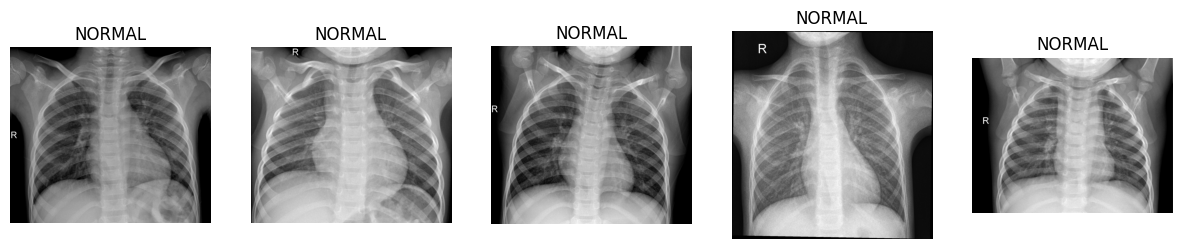

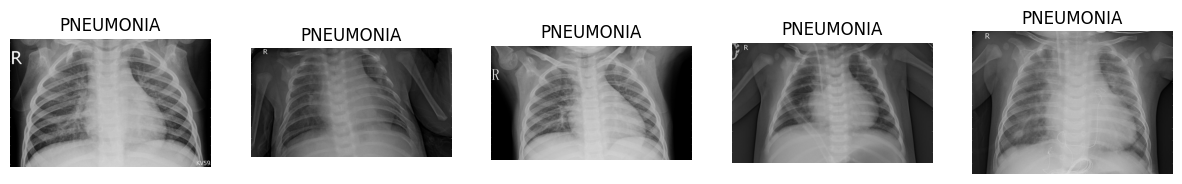

In [10]:
# Display some normal and pneumonia images from the training set
display_images(train_dir, 'NORMAL')
display_images(train_dir, 'PNEUMONIA')

Simple EDA

In [11]:
# Count number of images in each class
train_normal_count = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
train_pneumonia_count = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
val_normal_count = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
val_pneumonia_count = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
test_normal_count = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
test_pneumonia_count = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))

In [12]:
# Create a DataFrame for visualization
data = {
    'Class': ['Normal', 'Pneumonia'],
    'Train': [train_normal_count, train_pneumonia_count],
   'Test': [test_normal_count, test_pneumonia_count]
}
df = pd.DataFrame(data)


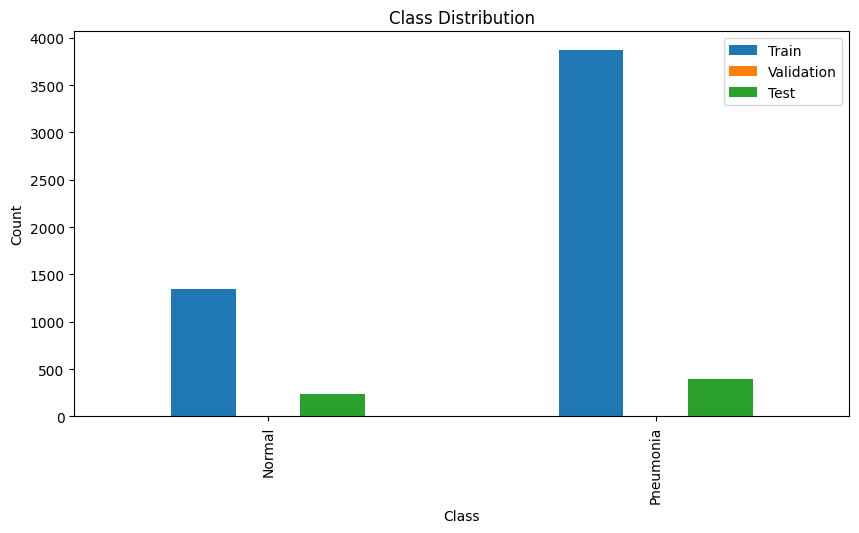

In [13]:
# Visualize class distribution
df.plot(kind='bar', x='Class', figsize=(10, 5))
plt.title('Class Distribution')
plt.ylabel('Count')
plt.show()

In [14]:
# Check for missing or corrupted images
def check_images(directory, class_name):
    image_files = os.listdir(os.path.join(directory, class_name))
    for image_file in image_files:
        img_path = os.path.join(directory, class_name, image_file)
        try:
            img = cv2.imread(img_path)
            if img is None:
                print(f"Corrupted image: {img_path}")
        except Exception as e:
            print(f"Error reading image {img_path}: {e}")

In [15]:
check_images(train_dir, 'NORMAL')
check_images(train_dir, 'PNEUMONIA')
check_images(val_dir, 'NORMAL')
check_images(val_dir, 'PNEUMONIA')
check_images(test_dir, 'NORMAL')
check_images(test_dir, 'PNEUMONIA')

ML Modelling

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:
# Define image data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/chest_xray/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
      '/content/chest_xray/val',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [22]:
# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
# Train the model
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 427ms/step - accuracy: 0.7245 - loss: 0.5897 - val_accuracy: 0.8125 - val_loss: 0.5623
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 405ms/step - accuracy: 0.8529 - loss: 0.3214 - val_accuracy: 0.6250 - val_loss: 0.7770
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 401ms/step - accuracy: 0.8682 - loss: 0.2950 - val_accuracy: 0.6875 - val_loss: 0.5776
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 401ms/step - accuracy: 0.8701 - loss: 0.2905 - val_accuracy: 0.7500 - val_loss: 0.5290
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 400ms/step - accuracy: 0.8938 - loss: 0.2460 - val_accuracy: 0.7500 - val_loss: 0.7502
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 401ms/step - accuracy: 0.8943 - loss: 0.2506 - val_accuracy: 0.7500 - val_loss: 0.5053
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 399ms/step - accuracy: 0.9084 - loss: 0.2269 - val_accuracy: 0.7500 - val_loss: 0.6787
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 396ms/step - accuracy: 0.9069 - loss: 0.2218 - val

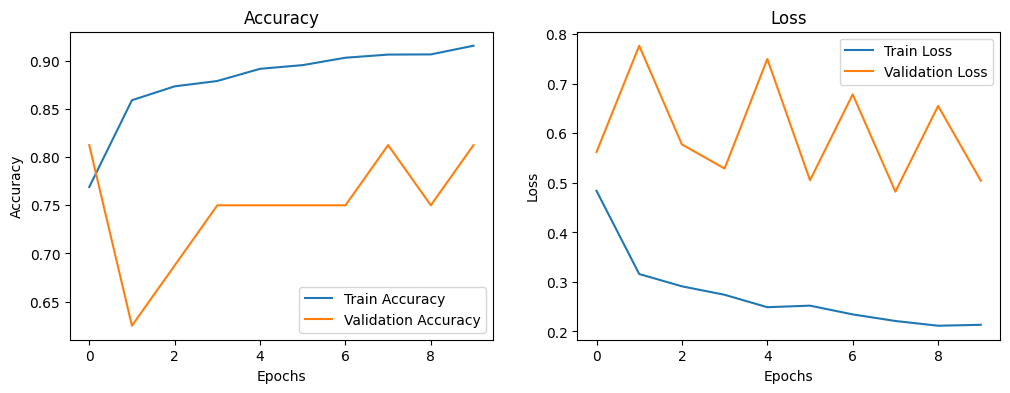

In [25]:
# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [26]:
# Save the model
model.save('models/cnn_model.h5')

 Evaluation

In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [28]:
# Load the model
model = tf.keras.models.load_model('models/cnn_model.h5')

In [30]:
# Define image data generator for test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/chest_xray/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 624 images belonging to 2 classes.


In [31]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy:.2f}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.8846 - loss: 0.3156
Test Accuracy: 0.88


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


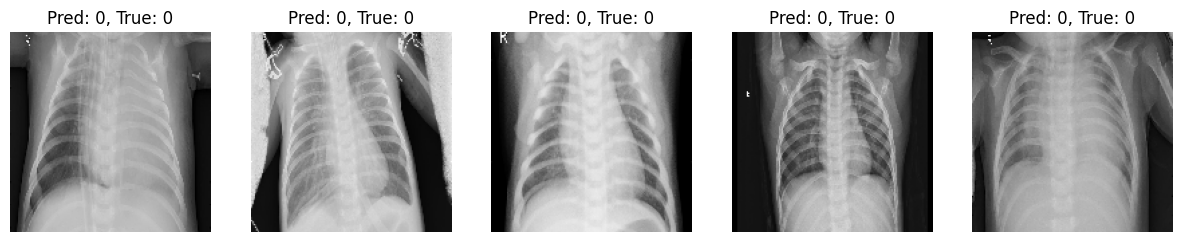

In [33]:
# Visualize some test images with predictions
import numpy as np
import cv2
import matplotlib.pyplot as plt

def display_test_images(model, test_generator, num_images=5):



    fig = plt.figure(figsize=(15, 5))
    for i in range(num_images):
        x, y = next(test_generator)  # Corrected here
        pred = model.predict(x)

        ax = fig.add_subplot(1, num_images, i + 1)
        ax.imshow(np.squeeze(x[0]))  # Assuming images are single-channel or RGB
        ax.set_title(f"Pred: {np.argmax(pred[0])}, True: {np.argmax(y[0])}")
        ax.axis('off')
    plt.show()

# Call the function
display_test_images(model, test_generator)


The MedVisionAI smallscale model achieves an accuracy of 0.88, indicating strong performance in analyzing X-ray images. This level of accuracy demonstrates the potential of the model to assist in medical diagnostics. However, there is room for improvement, especially in optimizing the model for robustness and generalization to diverse datasets. Ensuring rigorous validation and addressing edge cases will further enhance the system's reliability and clinical applicability.